# General plots for the paper

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import pickle
import os 

In [2]:
# set seed
rng = np.random.default_rng(42)

## 2-D density plot

In [3]:
# create contour plot for two 2-D gaussians same mean, one with correlation between the variables and one without 

mu = np.array([1.0, 2.0])
cov1 = np.array([[0.03, 0], [0, 0.07]])
cov2 = np.array([[0.1, 0.1], [0.1, 0.2]])

In [4]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [5]:
is_pos_def(cov2)

True

In [6]:
# generate samples from the multivariate normal distribution
x1 = rng.multivariate_normal(mu, cov1, size=5000)
x2 = rng.multivariate_normal(mu, cov2, size=5000)

In [7]:
x2.shape

(5000, 2)

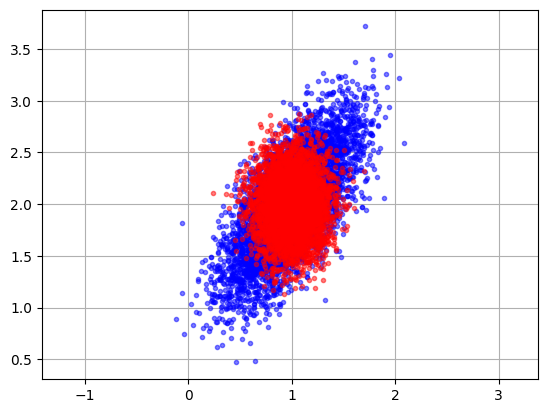

In [8]:
plt.plot(x2[:, 0], x2[:, 1], '.', alpha=0.5, color="blue")
plt.plot(x1[:, 0], x1[:, 1], '.', alpha=0.5, color="red")
plt.axis('equal')
plt.grid()
plt.show()

In [9]:
cmap1 = matplotlib.colormaps.get_cmap("Blues")
c1 = cmap1(0.5)[:3]
cmap2 = matplotlib.colormaps.get_cmap("Reds")
c2 = cmap2(0.5)[:3]

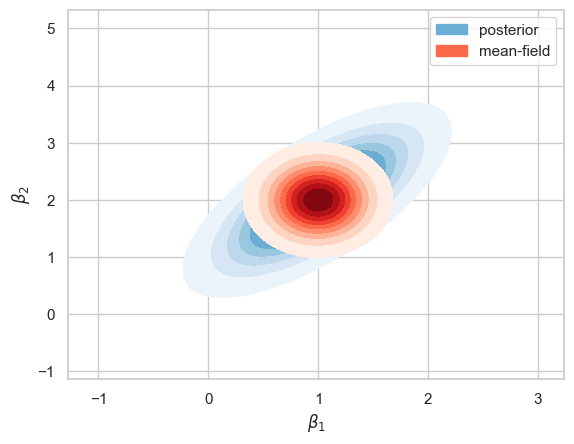

In [10]:
# create density plot
fig = plt.figure()

sns.set_theme(style="whitegrid")

sns.kdeplot(x=x2[:,0], y=x2[:,1], cmap="Blues", fill=True, bw_adjust=5)
sns.kdeplot(x=x1[:,0], y=x1[:,1], cmap="Reds", fill=True, bw_adjust=5)

red_patch = mpatches.Patch(color=c1, label='posterior')
blue_patch = mpatches.Patch(color=c2, label='mean-field')
plt.legend(handles=[red_patch, blue_patch])

plt.xlabel(r'$\beta_{1}$')
plt.ylabel(r'$\beta_{2}$')
plt.show()

In [11]:
current_directory = os.getcwd()
path = "../thesis/assets/plots"
filename = "plot1.pdf"  # You can use other formats like .jpg, .pdf, etc.

# Create the full path to the folder
folder_path = os.path.join(current_directory, path)

# Create the full path to the file
full_filepath = os.path.join(folder_path, filename)

# safe figure to assets/plots
fig.savefig(full_filepath)

## Pickle to store more complex data later on

In [158]:
# Specify the filename for exporting the object
current_directory = os.getcwd()
path = "../thesis/assets/plots"
filename = "data1.pickle"

# Create the full path to the folder
folder_path = os.path.join(current_directory, path)

# Create the full path to the file
full_filepath = os.path.join(folder_path, filename)

full_filepath

'/Users/SebLorek/Desktop/uni/master_statistics/semester_4/master_thesis/liesel-bbvi/playground/../thesis/assets/plots/plot1.pickle'

In [161]:
# Export the object using pickle
with open(filename, "wb") as file:
    pickle.dump(data, full_filepath)

TypeError: file must have a 'write' attribute